In [39]:
import tensorflow as tf
import tensorflow_io as tfio
import keras
from keras import layers
from keras.layers import Dense, Flatten, Conv2D
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import os
from IPython import display
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd
import pandas as pd

In [40]:
model = keras.models.load_model("./Training/processor.h5")

In [41]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [42]:
def preprocess(file_path, label):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [43]:
EVAL = os.path.join('Process')

In [44]:
eval = tf.data.Dataset.list_files(EVAL +'/*.wav')

In [45]:
data = tf.data.Dataset.zip((eval, tf.data.Dataset.from_tensor_slices(tf.ones(len(eval)))))

In [46]:
lengths = []
for file in os.listdir(os.path.join('Process')):
    tensor_wave = load_wav(os.path.join('Process', file))
    lengths.append(len(tensor_wave))

In [47]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

b'Process\\Homebot-TEST.wav'


<function matplotlib.pyplot.show(close=None, block=None)>

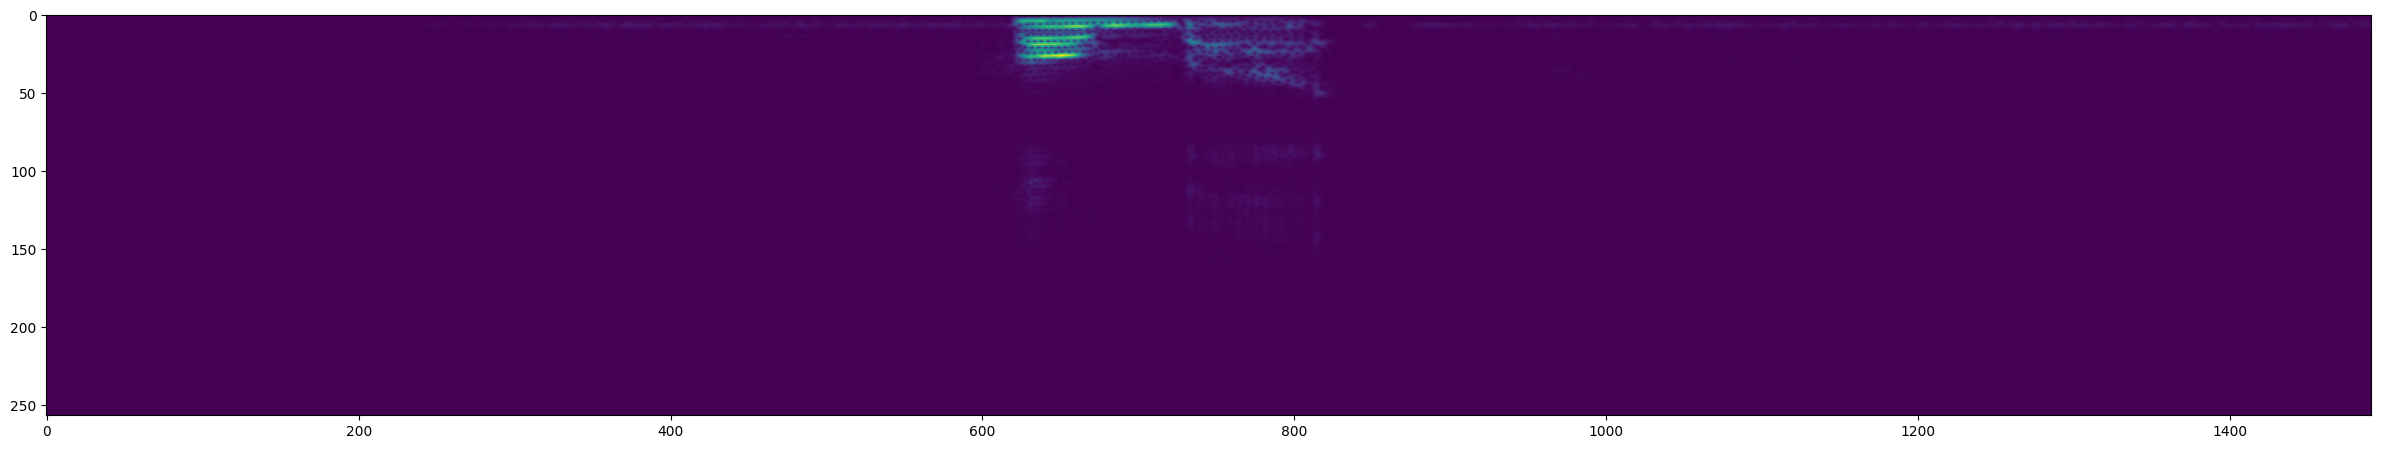

In [48]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [49]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [50]:
preds = model.predict(data)
preds

1/1 [==============================] - 2s 2s/step


array([[1.]], dtype=float32)

In [51]:
def wake():
    print("WAKE DETECTED")

In [52]:

from datetime import date
from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y")

In [53]:
results = ['1' if x > 0.5 else 0 for x in preds]
for i in range(len(results)):
    results[i] = bool(results[i])
    if(bool(results[i])):
        wake()
log = pd.DataFrame(preds)
log.to_csv('Logs' + '/' + 'log ' + now + '.csv', index=False)

WAKE DETECTED
